In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygetdata as gd

In [2]:
#importing from dirfiles

#locations and folder
dir_base = '/home/triv/Desktop/localBLASTTNG/'
dir_master = dir_base + 'master_2020-01-06-06-21-22'
dir_roach3 = dir_base + 'roach3_2020-01-06-06-21-56'

roach_num = 3 #using roach 3 rn

mode_dirfile = gd.RDONLY
data_master = gd.dirfile(dir_master, mode_dirfile)
data_roach3 = gd.dirfile(dir_roach3)

#getting data
RAm = data_master.getdata(b'RA')
DECm = data_master.getdata(b'DEC')
master_time = data_master.getdata(b'TIME') + data_master.getdata(b'TIME_USEC')*1e-6
roach_time = data_roach3.getdata(b'ctime_built_roach3')

I_vals = data_roach3.getdata(b'i_kid0150_roach3')
Q_vals = data_roach3.getdata(b'q_kid0150_roach3')
absIQ_vals = np.sqrt(I_vals**2 + Q_vals**2)
phase_vals = np.arctan2(Q_vals, I_vals)

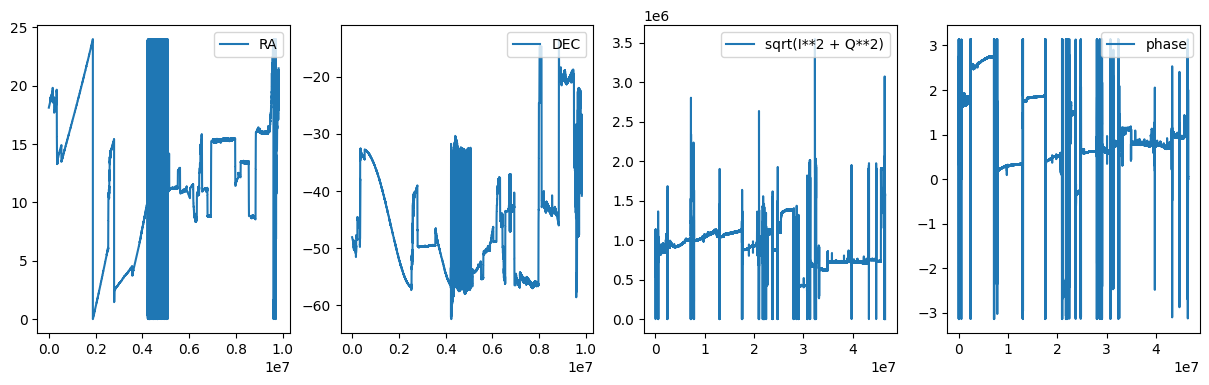

RA & DEC shape:  (9830900,) (9830900,)
Detector timestream shape:  (46531631,) (46531631,)
Master time: 
    min: 1578244880.069792, max: 1578343189.25718, avg. diff: 0.010000020078320739, clock speed: 99.99979921719574
Detector time: 
    min: 1578244917.5798242, max: 1578342886.964096, avg. diff: 0.002048015594482422, clock speed: 488.27753201396973


In [3]:
def view_data():
    # check vars
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,4))
    #fig.suptitle('')
    ax1.plot(RAm, label='RA')
    ax2.plot(DECm, label='DEC')
    ax3.plot(absIQ_vals, label='sqrt(I**2 + Q**2)')
    ax4.plot(phase_vals, label='phase')
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')
    ax3.legend(loc='upper right')
    ax4.legend(loc='upper right')
    plt.show()
    m_diff = np.diff(master_time)
    r_diff = np.diff(roach_time)
    print('RA & DEC shape: ', RAm.shape, DECm.shape)
    print('Detector timestream shape: ', absIQ_vals.shape, phase_vals.shape)
    print('Master time: ')
    print(f"    min: {np.min(master_time)}, max: {np.max(master_time)}, avg. diff: {np.mean(m_diff)}, clock speed: {1/np.mean(m_diff)}")
    print('Detector time: ')
    print(f"    min: {np.min(roach_time)}, max: {np.max(roach_time)}, avg. diff: {np.median(r_diff)}, clock speed: {1/np.median(r_diff)}")
    return

view_data()

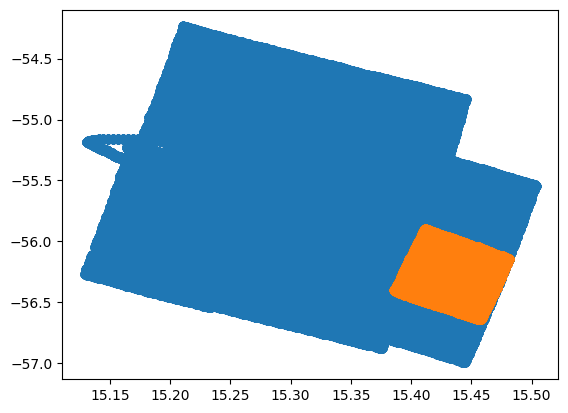

In [4]:
#setting scan area from RA and DEC master arrays

start = int(7.85e6)
stop = int(7.9722e6)

def show_scan_area():
    plt.scatter(RAm[7000000:7972200], DECm[7000000:7972200])
    plt.scatter(RAm[start:stop], DECm[start:stop])
    plt.show()
show_scan_area()

In [5]:
#Scaling Master and Detector arrays by time
DETinds = np.array([np.searchsorted(roach_time, t, side='left') for t in master_time]) #finds closest index in roach time for each master time
DETinds[DETinds == len(roach_time)] = len(roach_time) - 1 # fixed max index bug from np.searchsorted

#Scaled arrays (can be used with each other)
RA = RAm[start:stop]
DEC = DECm[start:stop]
PH = phase_vals[DETinds][start:stop]

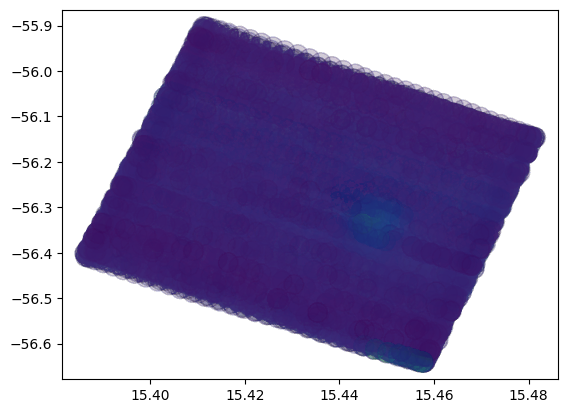

In [6]:
#Simple scatter map from detector
def scatter_map():
    plt.scatter(RA, DEC, c=PH, alpha=0.01, s=200)
scatter_map()

In [7]:
#Build map array from pixels
ra_bin = 0.0025
dec_bin = 0.02
r_pix = np.arange(np.min(RA), np.max(RA), ra_bin)
d_pix = np.arange(np.min(DEC), np.max(DEC), dec_bin)

rr, dd = np.meshgrid(r_pix,d_pix)

#populate map

def fill_coverage_map():
    Z = np.zeros((len(d_pix),len(r_pix)))
    for i in range(len(d_pix)):
        for j in range(len(r_pix)): #loop over pixel map
            det_inds = (RA >= r_pix[j]) & (RA < (r_pix[j] + ra_bin)) & (DEC >= d_pix[i]) & (DEC < (d_pix[i] + dec_bin)) # bining RA and DEC into pixel
            pix_val = det_inds.sum() #counts ra&dec for each pixel
            Z[i,j] = pix_val 
    return Z
 
def fill_phase_map():
    Z = np.zeros((len(d_pix),len(r_pix)))
    for i in range(len(d_pix)):
        for j in range(len(r_pix)): #loop over pixel map
            det_inds = (RA >= r_pix[j]) & (RA < (r_pix[j] + ra_bin)) & (DEC >= d_pix[i]) & (DEC < (d_pix[i] + dec_bin)) # bining RA and DEC into pixel
            det_vals = PH[det_inds] #phase values at each pixel from ts
            pix_val = np.mean(det_vals)
            Z[i,j] = pix_val
    return Z

cov_map = fill_coverage_map()
phase_map = fill_phase_map()

/home/triv/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/triv/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


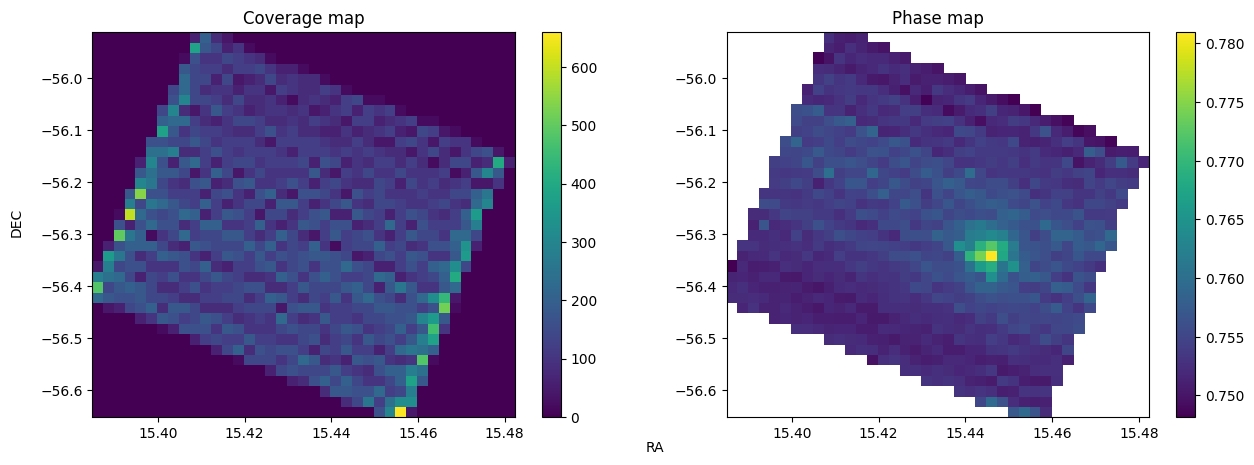

In [8]:
def show_maps():
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    a = ax1.pcolor(rr,dd,cov_map)
    ax1.set_title('Coverage map')
    b = ax2.pcolor(rr,dd,phase_map)
    ax2.set_title('Phase map')
    fig.colorbar(a)
    fig.colorbar(b)
    fig.text(0.5, 0.04, 'RA', ha='center')
    fig.text(0.07, 0.5, 'DEC', va='center', rotation='vertical')
    plt.show()
show_maps()

In [9]:
%matplotlib qt
plt.pcolor(rr,dd,phase_map)
plt.colorbar()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Phase map')
plt.show()

In [10]:
#%matplotlib inline